# Elo Merchant Category Recommendation - Stacking
End date: _2019. february 19._<br/>

This tutorial notebook is part of a series for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. LynxKite does not yet support some of the data preprocessing, thus they need to be done in Python. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

Inspired by [MultiModel + RIDGE + STACKING](https://www.kaggle.com/ashishpatel26/rmse-3-66-multimodel-ridge-stacking)<br/>
[KazaNova's presentation on stacking](https://www.coursera.org/lecture/competitive-data-science/stacking-Qdtt6)

In [1]:
import gc
import random
import warnings
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.externals import joblib
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold, train_test_split
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score

random.seed(1)
warnings.filterwarnings("ignore")

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Feature engineering

### Train & test data

In [ ]:
df_train = pd.read_csv("input/train.csv", parse_dates=["first_active_month"])
df_train = reduce_mem_usage(df_train)
print("{:,} observations and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

In [ ]:
df_test = pd.read_csv("input/test.csv", parse_dates=["first_active_month"])
df_test = reduce_mem_usage(df_test)
print("{:,} observations and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

In [ ]:
df_train['first_active_month'] = pd.to_datetime(df_train['first_active_month'])
df_train['elapsed_days'] = (datetime.date(2018, 2, 1) - df_train['first_active_month'].dt.date).dt.days

In [ ]:
df_test['first_active_month'] = pd.to_datetime(df_test['first_active_month'])
df_test['elapsed_days'] = (datetime.date(2018, 2, 1) - df_test['first_active_month'].dt.date).dt.days

### Transactions

In [ ]:
%%time
df_hist_trans = pd.read_csv('input/historical_transactions.csv', parse_dates=['purchase_date'])
df_hist_trans = reduce_mem_usage(df_hist_trans)
print('Number of historical transactions: {:,}'.format(len(df_hist_trans)))

In [ ]:
%%time
df_new_trans = pd.read_csv('input/new_merchant_transactions.csv', parse_dates=['purchase_date'])
df_new_trans = reduce_mem_usage(df_new_trans)
print('Number of new transactions: {:,}'.format(len(df_new_trans)))

In [ ]:
df_new_trans.isna().sum()

Missing data handling (why these values?)

In [ ]:
for df in [df_hist_trans, df_new_trans]:
    df['category_2'].fillna(1.0, inplace=True)
    df['category_3'].fillna('A', inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)

Date handling

In [ ]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_weekend'] = (df[source_column].dt.weekday >=5).astype(int)
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    
    return df

In [ ]:
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'N': 0, 'Y': 1})

df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
df_hist_trans = create_date_features(df_hist_trans, 'purchase_date', 'purchase')

In [ ]:
df_new_trans['authorized_flag'] = df_new_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_trans['category_1'] = df_new_trans['category_1'].map({'N': 0, 'Y': 1})

df_new_trans['purchase_date'] = pd.to_datetime(df_new_trans['purchase_date'])
df_new_trans = create_date_features(df_new_trans, 'purchase_date', 'purchase')

In [ ]:
df_hist_trans['month_diff'] = ((datetime.date(2018, 12, 1) - df_hist_trans['purchase_date'].dt.date).dt.days)//30
df_hist_trans['month_diff'] += df_hist_trans['month_lag']

In [ ]:
df_new_trans['month_diff'] = ((datetime.date(2018, 12, 1) - df_new_trans['purchase_date'].dt.date).dt.days)//30
df_new_trans['month_diff'] += df_new_trans['month_lag']

In [ ]:
df_hist_trans = reduce_mem_usage(df_hist_trans)

In [ ]:
df_new_trans = reduce_mem_usage(df_new_trans)

#### Aggregation

In [ ]:
def aggregate_transactions(df, prefix):
    agg_funcs = {
        'authorized_flag': ['sum', 'mean'],

        'card_id': ['size'],
        'category_1': ['sum', 'mean'],
        
        'installments': ['sum', 'max', 'min', 'mean', 'var'],

        'merchant_category_id': ['nunique'],
        'merchant_id': ['nunique'],
        'month_diff': ['mean'],
        'month_lag': ['max','min','mean','var'],

        'purchase_amount': ['sum', 'max', 'min', 'mean', 'var'],
        'purchase_date': ['max', 'min'],
        'purchase_dayofweek': ['nunique'],
        'purchase_hour': ['nunique'],
        'purchase_month': ['nunique'],
        'purchase_year': ['nunique'],
        'purchase_weekend': ['sum', 'mean'],
        'purchase_weekofyear': ['nunique'],

        'subsector_id': ['nunique']
    }

    df['category_2_mean'] = df.groupby(['category_2'])['purchase_amount'].transform('mean')
    df['category_3_mean'] = df.groupby(['category_3'])['purchase_amount'].transform('mean')

    df_agg = df.groupby('card_id').agg(agg_funcs)
    df_agg.columns = [prefix + '_' + '_'.join(col).strip() for col in df_agg.columns.values]
    df_agg.reset_index(drop=False, inplace=True)
    df_agg[prefix + '_purchase_date_diff'] = (df_agg[prefix + '_purchase_date_max'] - df_agg[prefix + '_purchase_date_min']).dt.days
    df_agg[prefix + '_purchase_date_average'] = df_agg[prefix + '_purchase_date_diff']/df_agg[prefix + '_card_id_size']
    df_agg[prefix + '_purchase_date_uptonow'] = (datetime.datetime.today() - df_agg[prefix + '_purchase_date_max']).dt.days

    df = (df_agg.groupby('card_id').size().reset_index(name='{}_transactions_count'.format(prefix)))
    df_agg = pd.merge(df, df_agg, on='card_id', how='left')
    return df_agg

In [ ]:
df_hist_agg = aggregate_transactions(df_hist_trans, 'hist')
df_new_agg = aggregate_transactions(df_new_trans, 'new')

df_train = df_train.merge(df_hist_agg, on='card_id', how='left')
df_train = df_train.merge(df_new_agg, on='card_id', how='left')

df_test = df_test.merge(df_hist_agg, on='card_id', how='left')
df_test = df_test.merge(df_new_agg, on='card_id', how='left')

In [ ]:
df_hist_agg[:3]

In [ ]:
del df_hist_trans, df_new_trans, df_hist_agg, df_new_agg
gc.collect()

In [ ]:
df_train['hist_first_buy'] = (df_train['hist_purchase_date_min'] - df_train['first_active_month']).dt.days
df_train['new_first_buy'] = (df_train['new_purchase_date_min'] - df_train['first_active_month']).dt.days

df_test['hist_first_buy'] = (df_test['hist_purchase_date_min'] - df_test['first_active_month']).dt.days
df_test['new_first_buy'] = (df_test['new_purchase_date_min'] - df_test['first_active_month']).dt.days

In [ ]:
for f in ['hist_purchase_date_max', 'hist_purchase_date_min', 'new_purchase_date_max', 'new_purchase_date_min']:
    df_train[f] = df_train[f].astype(np.int64) * 1e-9
    df_test[f] = df_test[f].astype(np.int64) * 1e-9

df_train['card_id_total'] = df_train['hist_card_id_size'] + df_train['new_card_id_size']
df_test['card_id_total'] = df_test['hist_card_id_size'] + df_test['new_card_id_size']

df_train['purchase_amount_total'] = df_train['hist_purchase_amount_sum'] + df_train['new_purchase_amount_sum']
df_test['purchase_amount_total'] = df_test['hist_purchase_amount_sum'] + df_test['new_purchase_amount_sum']

In [ ]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

In [ ]:
for f in ['feature_1', 'feature_2', 'feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [ ]:
df_train.to_csv('preprocessed/train_merged.csv')
df_test.to_csv('preprocessed/test_merged.csv')

Loading previously saved model

In [3]:
df_train = pd.read_csv('preprocessed/train_merged.csv')
df_train = reduce_mem_usage(df_train)
print("{:,} observations and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

df_test = pd.read_csv('preprocessed/test_merged.csv')
df_test = reduce_mem_usage(df_test)
print("{:,} observations and {} features in train set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage: 130.94 MB
Reduced memory usage: 36.97 MB (71.8% reduction)
201,917 observations and 85 features in train set.
Starting memory usage: 78.28 MB
Reduced memory usage: 22.28 MB (71.5% reduction)
123,623 observations and 83 features in train set.


### Loading possible outliers (bag of catboost)

df_train_cb.to_csv('preprocessed/train_bag_of_catboost_outliers.csv', index=False)

### Loading possible outliers (Bea's predictions)

In [4]:
df_train_po = pd.read_csv("preprocessed/possible_outliers_train_gt0.9.csv")
df_train_po = reduce_mem_usage(df_train_po)
print("{:,} observations and {} features in train set.".format(df_train_po.shape[0], df_train_po.shape[1]))

Starting memory usage:  3.08 MB
Reduced memory usage:  1.73 MB (43.7% reduction)
201,917 observations and 2 features in train set.


In [5]:
df_train_po[df_train_po['possible_out'] == 1].count()

card_id         31039
possible_out    31039
dtype: int64

In [6]:
df_test_po = pd.read_csv("preprocessed/possible_outliers_test_gt0.9.csv")
df_test_po = reduce_mem_usage(df_test_po)
print("{:,} observations and {} features in train set.".format(df_test_po.shape[0], df_test_po.shape[1]))

Starting memory usage:  1.89 MB
Reduced memory usage:  1.06 MB (43.7% reduction)
123,623 observations and 2 features in train set.


In [7]:
len(df_train_po[df_train_po['possible_out'] == 1]), len(df_test_po[df_test_po['possible_out'] == 1])

(31039, 335)

In [8]:
df_train = df_train.merge(df_train_po, on='card_id', how='left')
df_test = df_test.merge(df_test_po, on='card_id', how='left')

### Loading LynxKite features

In [9]:
df_train_lk = pd.read_csv("preprocessed/lk_feature_train.csv")
df_train_lk = reduce_mem_usage(df_train_lk)
print("{:,} observations and {} features in train set.".format(df_train_lk.shape[0], df_train_lk.shape[1]))

Starting memory usage:  4.62 MB
Reduced memory usage:  1.93 MB (58.3% reduction)
201,917 observations and 3 features in train set.


In [10]:
df_test_lk = pd.read_csv("preprocessed/lk_feature_test.csv")
df_test_lk = reduce_mem_usage(df_test_lk)
print("{:,} observations and {} features in train set.".format(df_test_lk.shape[0], df_test_lk.shape[1]))

Starting memory usage:  2.83 MB
Reduced memory usage:  1.18 MB (58.3% reduction)
123,623 observations and 3 features in train set.


In [11]:
df_train = df_train.merge(df_train_lk, on='card_id', how='left')
df_test = df_test.merge(df_test_lk, on='card_id', how='left')

### Training
[LightGBM parameter tuning](https://testlightgbm.readthedocs.io/en/latest/Parameters-tuning.html)<br/>
[What is LightGBM, How to implement it? How to fine tune the parameters?](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc)

In [17]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month', 'target', 'outliers', 'is_outlier']]
target = df_train['target']
del df_train['target']

#### LightGBM

In [18]:
%%time
param = {
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "boosting": "gbdt",

    "feature_fraction": 0.9,
    #"feature_fraction_seed": 1,

    "lambda_l1": 0.1,
    "learning_rate": 0.01,

    #"max_bin": 5,
    'max_depth': -1,
    "metric": "rmse",
    #"min_data_in_leaf": 30,
    #"min_gain_to_split": 0.1,
    "min_child_samples": 20,
    #"num_boost_round": 100,
    "num_leaves": 31,
    "nthread": -1,

    "objective": "regression",

    "random_state": 402,
    "verbosity": -1
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=402)
oof_lgbm = np.zeros(len(df_train))
predictions_lgbm = np.zeros(len(df_test))
feature_importance_lgbm = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, df_train['possible_out'].values)):
    print("\nFold {}.".format(fold_+1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    model_lgbm = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof_lgbm[val_idx] = model_lgbm.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=model_lgbm.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["importance"] = model_lgbm.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_lgbm = pd.concat([feature_importance_lgbm, fold_importance_df], axis=0)
    
    predictions_lgbm += model_lgbm.predict(df_test[df_train_columns], num_iteration=model_lgbm.best_iteration) / folds.n_splits


Fold 1.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.65131	valid_1's rmse: 3.77266
[200]	training's rmse: 3.5728	valid_1's rmse: 3.73938
[300]	training's rmse: 3.5226	valid_1's rmse: 3.72582
[400]	training's rmse: 3.48413	valid_1's rmse: 3.71832
[500]	training's rmse: 3.45211	valid_1's rmse: 3.71349
[600]	training's rmse: 3.42438	valid_1's rmse: 3.70994
[700]	training's rmse: 3.39998	valid_1's rmse: 3.70699
[800]	training's rmse: 3.37942	valid_1's rmse: 3.70577
[900]	training's rmse: 3.35821	valid_1's rmse: 3.70347
[1000]	training's rmse: 3.33976	valid_1's rmse: 3.70214
[1100]	training's rmse: 3.3216	valid_1's rmse: 3.70126
[1200]	training's rmse: 3.3051	valid_1's rmse: 3.7005
[1300]	training's rmse: 3.28818	valid_1's rmse: 3.6998
[1400]	training's rmse: 3.2728	valid_1's rmse: 3.69902
[1500]	training's rmse: 3.25809	valid_1's rmse: 3.69854
[1600]	training's rmse: 3.24244	valid_1's rmse: 3.69807
[1700]	training's rmse: 3.22804	valid_1's rmse: 

In [19]:
cv_score_lgbm = np.sqrt(mean_squared_error(oof_lgbm, target))
print("CV score: {:.6f}".format(cv_score_lgbm))

CV score: 3.654144


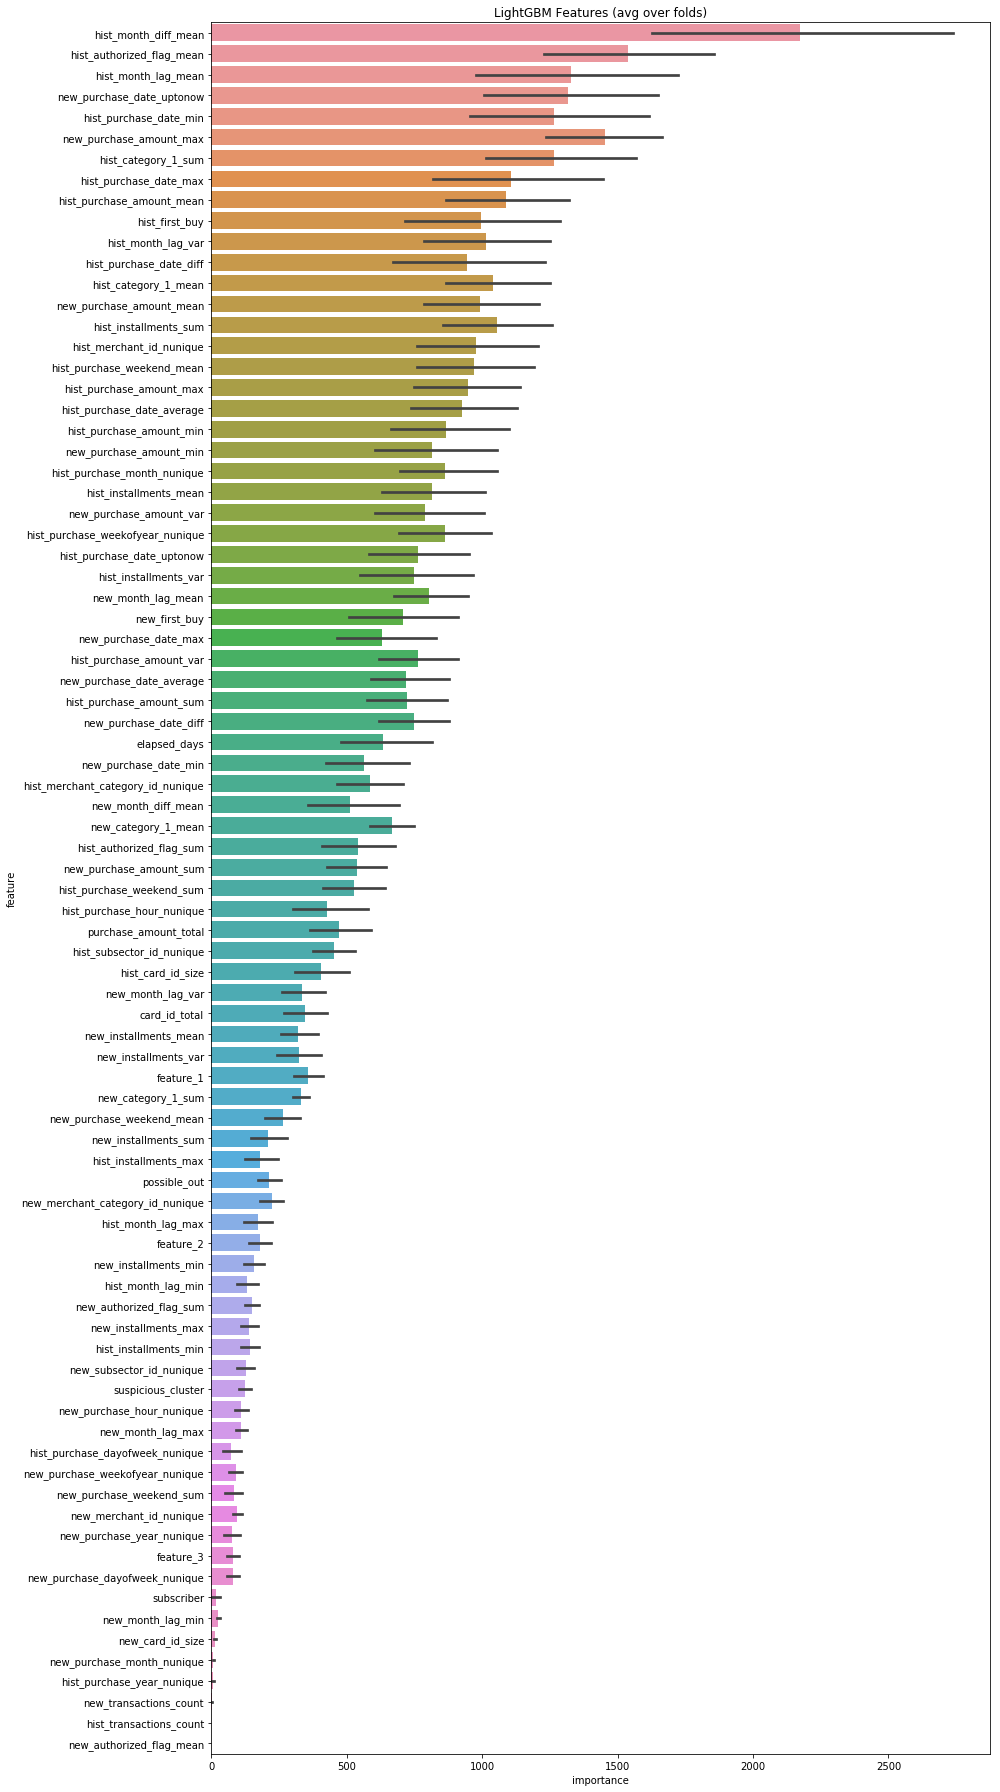

In [20]:
cols = (feature_importance_lgbm[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features_lgbm = feature_importance_lgbm.loc[feature_importance_lgbm.feature.isin(cols)]

plt.figure(figsize=(14, 25))
sns.barplot(x="importance", y="feature", data=best_features_lgbm.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
model_lgbm.save_model("models/lightgbm_{:.6f}.txt".format(cv_score_lgbm))

In [ ]:
model_lgbm = lgb.Booster(model_file='models/lightgbm_3.655203.txt')

#### CatBoost

In [21]:
list(set(df_train[df_train_columns].columns) - set(df_train[df_train_columns]._get_numeric_data().columns))

[]

There is no real categorical columns in the training set.

In [22]:
category_columns = df_train[df_train_columns].select_dtypes(include=['int8', 'int16', 'int32', 'int64']).columns.tolist()

In [23]:
for i in category_columns:
       print(str(df_train[df_train_columns].columns.get_loc(i)) + ',')

3,
4,
7,
10,
11,
12,
15,
16,
18,
19,
29,
30,
31,
32,
35,
36,
37,
39,
76,
80,
81,
82,


In [ ]:
%%time
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
oof_cat = np.zeros(len(df_train))
predictions_cat = np.zeros(len(df_test))
feature_importance_cat = pd.DataFrame()

model_cat = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    bagging_temperature = 0.9,
    od_type='Iter',
    #metric_period = 100,
    od_wait=50
)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, df_train['possible_out'].values)):
    print("\nFold {}.".format(fold_+1))
    trn_data = df_train.iloc[trn_idx][df_train_columns]
    trn_label = target.iloc[trn_idx]
    val_data = df_train.iloc[val_idx][df_train_columns]
    val_label = target.iloc[val_idx]

    num_round = 10000
    model_cat.fit(trn_data, trn_label, eval_set=(val_data, val_label), cat_features=np.array([3, 4, 7, 10, 11, 12, 15, 16, 18, 19, 29, 30, 31, 32, 35, 36, 37, 39, 76, 80, 81, 82]), use_best_model=True, verbose=100)
    
    oof_cat[val_idx] = model_cat.predict(df_train.iloc[val_idx][df_train_columns])
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["importance"] = model_cat.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_cb = pd.concat([feature_importance_cat, fold_importance_df], axis=0)
    
    predictions_cat += model_cat.predict(df_test[df_train_columns].fillna(0)) / folds.n_splits


Fold 1.
0:	learn: 3.8564959	test: 3.8671581	best: 3.8671581 (0)	total: 487ms	remaining: 8m 6s
100:	learn: 3.6633001	test: 3.6997890	best: 3.6997890 (100)	total: 33.5s	remaining: 4m 57s
200:	learn: 3.6401100	test: 3.6909489	best: 3.6909079 (199)	total: 1m 4s	remaining: 4m 16s
300:	learn: 3.6244456	test: 3.6871839	best: 3.6871805 (299)	total: 1m 43s	remaining: 3m 59s
400:	learn: 3.6095112	test: 3.6837522	best: 3.6837517 (399)	total: 2m 17s	remaining: 3m 25s
500:	learn: 3.5959388	test: 3.6820738	best: 3.6820371 (499)	total: 2m 49s	remaining: 2m 49s
600:	learn: 3.5841467	test: 3.6814911	best: 3.6814911 (600)	total: 3m 22s	remaining: 2m 14s
700:	learn: 3.5699976	test: 3.6809006	best: 3.6804636 (696)	total: 3m 58s	remaining: 1m 41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.680463635
bestIteration = 696

Shrink model to first 697 iterations.

Fold 2.
0:	learn: 3.8569052	test: 3.8646026	best: 3.8646026 (0)	total: 338ms	remaining: 5m 37s


In [ ]:
cv_score_cat = np.sqrt(mean_squared_error(oof_cat, target))
print("CV score: {:.6f}".format(cv_score_cat))

#### XGBoost

In [ ]:
%%time
params = {
    'colsample_bytree': 0.8,
    'eta': 0.05, # 0.005
    'eval_metric': 'rmse',
    'max_depth': 20,
    'objective': 'reg:linear',
    'random_state': 1,
    'silent': True,
    'subsample': 0.8
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=402)
oof_xgb = np.zeros(len(df_train))
predictions_xgb = np.zeros(len(df_test))
feature_importance_xgb = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, df_train['possible_out'].values)):
    print("\nFold {}.".format(fold_+1))
    trn_data = xgb.DMatrix(data=df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]

    num_round = 10000
    model_xgb = xgb.train(params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb[val_idx] = model_xgb.predict(xgb.DMatrix(df_train.iloc[val_idx][df_train_columns]), ntree_limit=model_xgb.best_ntree_limit+50)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_lxgb = pd.concat([feature_importance_xgb, fold_importance_df], axis=0)
    
    predictions_xgb += model_xgb.predict(xgb.DMatrix(df_test[df_train_columns]), ntree_limit=model_xgb.best_ntree_limit+50) / folds.n_splits

In [ ]:
cv_score_xgb = np.sqrt(mean_squared_error(oof_xgb, target))
print("CV score: {:.6f}".format(cv_score_xgb))

In [ ]:
joblib.dump(model_xgb, "models/xgboost_{:.6f}.pkl".format(cv_score_xgb), compress=True)

In [ ]:
model_xgb = joblib.load('models/xgboost_3.657233.pkl')

In [ ]:
sub_df = pd.DataFrame({
    "card_id": df_test["card_id"].values
})

sub_df["target"] = predictions
sub_df.to_csv("output/xgboost_{:.6f}.csv".format(cv_score), index=False)

#### Meta model

In [ ]:
train_stack = np.vstack([oof_lgbm, oof_xgb, oof_cat]).transpose()
test_stack = np.vstack([predictions_lgbm, predictions_xgb, predictions_cat]).transpose()

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("\nFold {}.".format(fold_+1))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    model_ridge = Ridge(alpha=100)
    model_ridge.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = model_ridge.predict(val_data)
    predictions_stack += model_ridge.predict(test_stack) / 5

In [ ]:
cv_score_stack = np.sqrt(mean_squared_error(oof_stack, target))
print("CV score: {:.6f}".format(cv_score_stack))

In [ ]:
sub_df = pd.DataFrame({
    "card_id": df_test["card_id"].values
})

sub_df["target"] = predictions_stack
sub_df.to_csv("output/stacked_{:.6f}.csv".format(cv_score_stack), index=False)

### Weighted averaging the predicted outliers

In [ ]:
sub_df = pd.DataFrame({
    "card_id": df_test["card_id"].values
})

sub_df["target"] = predictions_stack

In [ ]:
df_test_po[df_test_po['possible_out'] == 1].count()

In [ ]:
sub_df = sub_df.merge(df_test_po, on='card_id', how='left')

In [ ]:
sub_df[sub_df['possible_out'] == 1][:5]

In [ ]:
sub_df['target'] = sub_df.apply(lambda row: row['target'] if row['possible_out'] == 0 else (0.9 * row['target'] - 33.219281 * 0.1), axis = 1)

In [ ]:
sub_df[sub_df['possible_out'] == 1][:5]

In [ ]:
sub_df.drop('possible_out', axis=1, inplace=True)

In [ ]:
sub_df.to_csv("output/stacked_wavg_{:.6f}.csv".format(cv_score_stack), index=False)
print("output/lgbm_xgboost_cat_stacking_{:.6f}.csv".format(cv_score_stack))

[Just Train Data - LGB & XGB & CatBoost w/ Blending](https://www.kaggle.com/silverstone1903/just-train-data-lgb-xgb-catboost-w-blending/data)<br/>
[MultiModel + RIDGE + STACKING](https://www.kaggle.com/ashishpatel26/rmse-3-66-multimodel-ridge-stacking)
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/75935